In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from aeon.classification.convolution_based import MultiRocketHydraClassifier, HydraClassifier, RocketClassifier
from aeon.transformations.collection.convolution_based import HydraTransformer, Rocket
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from downtime import load_dataset
from sklearn.pipeline import make_pipeline, make_union
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import FunctionTransformer

import os
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import softmax
from sklearn.linear_model import RidgeClassifier


In [3]:
os.chdir('..')

In [ ]:
from experiments.data.data import get_data
from mascots.explainer.borf import BorfExplainer
from bin.utils.models import LSTM
import torch
import os
from torch import Tensor
from bin.utils.models import LSTM
from torch.utils.data import DataLoader, TensorDataset
from mascots.explainer.pipeline import get_borf_config
from experiments.models.classifier import GradientInceptionTimeClassifier
import tensorflow as tf
from pathlib import Path

2025-06-04 09:10:13.859583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 09:10:13.868575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749021013.879833   17988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749021013.883118   17988 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 09:10:13.894727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
X_train, y_train, X_test, y_test = get_data('TwoLeadECG')

In [6]:
class RidgeClassifierWithProba(RidgeClassifier):
    def __init__(self, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def predict_proba(self, X):
        d = self.decision_function(X) / self.temperature
        if len(d.shape) == 1:
            d = np.c_[-d, d]
        return softmax(d)

model1 = HydraTransformer()
model2 = Rocket()

In [7]:
pipeline = make_pipeline(
    make_union(
        make_pipeline(
            model1,
            ),
        model2),
    RidgeClassifierWithProba())
pipeline.fit(X_train, y_train)
# pipeline.predict_proba(X_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('hydratransformer',
                                                                  HydraTransformer())])),
                                                ('rocket', Rocket())])),
                ('ridgeclassifierwithproba', RidgeClassifierWithProba())])

In [8]:
pipeline.score(X_test, y_test)

0.9991220368744512

In [9]:
with torch.no_grad():
    explainer = BorfExplainer(pipeline.predict, pipeline.predict_proba, get_borf_config(np.array(X_train).shape))
    scores = explainer.build(np.array(X_train), RandomForestClassifier(n_estimators=100, max_features=0.01), attribution_args={'mode': 'deep'})

2025-06-04 09:10:22.122 | INFO     | borf.explainer.borf:__init__:47 - Borf #configs: 4
2025-06-04 09:10:22.125 | INFO     | borf.explainer.borf:__init__:48 - Borf #configs: [{'window_size': 8, 'stride': 1, 'dilation': 1, 'word_length': 4, 'alphabet_size': 3}, {'window_size': 16, 'stride': 1, 'dilation': 1, 'word_length': 4, 'alphabet_size': 3}, {'window_size': 32, 'stride': 1, 'dilation': 1, 'word_length': 4, 'alphabet_size': 3}, {'window_size': 64, 'stride': 1, 'dilation': 1, 'word_length': 4, 'alphabet_size': 3}]


(23, 1, 82)
<class 'numpy.ndarray'>


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 98.3 K | train
----------------------------------------------
98.3 K    Trainable params
0         Non-trainable params
98.3 K    Total params
0.393     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim

In [10]:
scores

{'accuracy': np.float64(0.9565217391304348),
 'cross-entropy': np.float32(-0.21493293),
 'mse': np.float32(0.020713128),
 'r2': 0.8568806648254395}

In [11]:
IDX: int = 6

In [12]:
np.random.seed(None)
seed = np.random.random_integers(1, 1e5)

counterfactual, meta = explainer.counterfactual(
    np.array(X_test[IDX:(IDX+1)]),
    target_cls=0,
    max_borf_changes=20,
    n_restarts=1, 
    select_top_k=6,
    # min_symbol_size=8,
    # max_symbol_size=4,
    # min_word_len_change=16,
    # max_word_len_change=16,
    C=0.1,
    seed=seed
)

/tmp/ipykernel_17988/3594327545.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 100000.0 + 1) instead
  seed = np.random.random_integers(1, 1e5)
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/dawid/miniconda3/envs/borf/lib/python3.11/sit

In [15]:
import pickle as pkl
with open('ARTICLE_ASSET_hydra_copy.pkl', 'rb') as f:
    meta = pkl.load(f)

In [16]:
if 'effective_iter' in meta[0].keys():
    del meta[0]['effective_iter']

In [17]:
cnt_steps = list(map(lambda x: x['new_obs'], meta[0].values()))
cnt_shapes = list(map(lambda x: x['added_shapes_candidates'][x['selected_swap'][0]].tolist(), meta[0].values()))
cnt_shapes_removed = list(map(lambda x: x['removed_shapes_candidates'][x['selected_swap'][0]].tolist(), meta[0].values()))
cnt_window_sizes = list(map(lambda x: x['windows_size'][0], meta[0].values()))
cnt_idx = list(map(lambda x: x['indicies'][x['selected_swap'][0]].tolist(), meta[0].values()))

In [18]:
# symbol_map = {
#     0: 'low',
#     1: 'med',
#     2: 'high'
# }

symbol_map = {
    0: 0,
    1: 1,
    2: 2
}

In [19]:
steps = np.arange(np.array(X_train).shape[2])

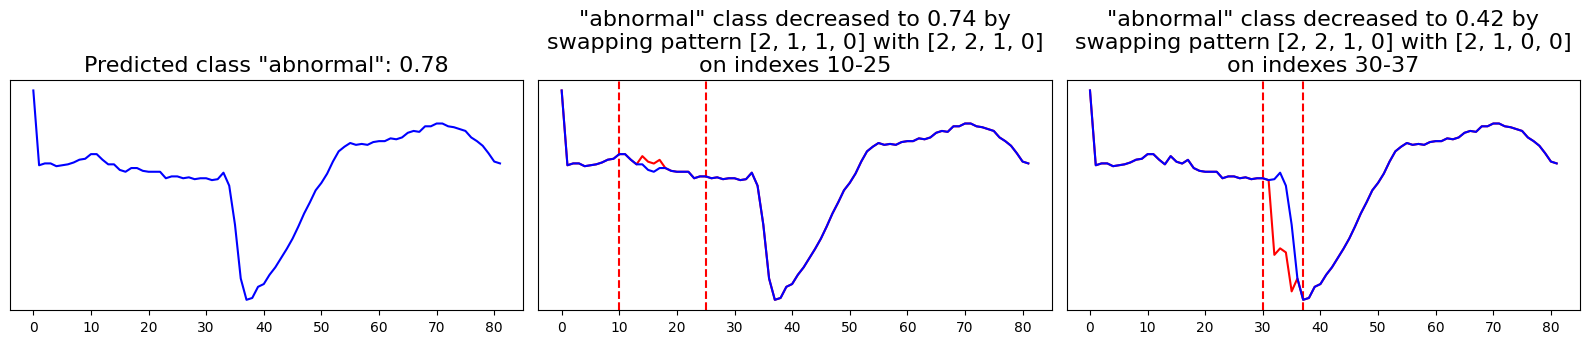

In [21]:
ncols = 3
nrows = (len(cnt_steps)+1) // ncols + 1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()

probs_cnt = pipeline.predict_proba(X_test[[IDX],:,:])[0]
ax[0].plot(steps, X_test[IDX,0,:], c='b')
# ax[0].set_title(f"Original observation\nCounterfactual class 'bell' prob: {probs_cnt[1].item():.2f}\nOriginal class 'cylinder' prob: {probs_cnt[0].item():.2f}")
ax[0].set_title(f'Predicted class "abnormal": {probs_cnt[1].item():.2f}', fontsize=16)
# ax[0].set_ylim((-2.0,2.7))
# ax[0].set_xticks([])
ax[0].set_yticks([])


for idx in range(len(cnt_steps)):
    new_cnt = cnt_steps[idx][0,0,:]
    probs_cnt = pipeline.predict_proba(cnt_steps[idx][[0],:,:])
    if idx == 0:
        old_cnt = X_test[IDX,0,:]
    else:
        old_cnt = cnt_steps[idx-1][0,0,:]
        
    area = np.arange(X_test.shape[2])[new_cnt-old_cnt != 0]
    
    m, std = old_cnt[area].mean(), old_cnt[area].std()
    
    cnt_shapes_removed_str = [symbol_map[el] for el in cnt_shapes_removed[idx]]
    cnt_shapes_str = [symbol_map[el] for el in cnt_shapes[idx]]
    
    ax[idx+1].axvline(cnt_idx[idx][0], c='r', linestyle='--')
    ax[idx+1].axvline(cnt_idx[idx][-1], c='r', linestyle='--')
        
    ax[idx+1].plot(steps, new_cnt, c='r')
    ax[idx+1].plot(steps, old_cnt, c='b')
    probs_org = pipeline.predict_proba(old_cnt[torch.newaxis,torch.newaxis,:])
        
    # ax[idx+1].legend(loc='upper left')
    # ax[idx].set_xlim(area.min(), area.max())
    
    change = (probs_cnt - probs_org)[0]
    
    change_str = f'"abnormal" class decreased to {probs_cnt[0][1]:.2f} by\n'+\
    f"swapping pattern {cnt_shapes_removed_str} with {cnt_shapes_str}\n"+\
    f"on indexes {cnt_idx[idx][0]}-{cnt_idx[idx][-1]}"
    ax[idx+1].set_title(change_str, fontsize=16)
    # ax[idx+1].set_ylim((-2, 2.7))
    # ax[idx+1].set_xticks([])
    ax[idx+1].set_yticks([])
    
# ax[len(cnt_steps)].plot(steps, X_train[4,0,:], c='b')
# ax[len(cnt_steps)].set_title('Counterfactual class prototype')
# ax[len(cnt_steps)].set_ylim((-2, 2.5))
    
for idx in range(len(cnt_steps)+1, nrows*ncols):
    fig.delaxes(ax[idx])

plt.tight_layout()

plt.savefig('media/article/results-hydra.pdf')